In [7]:
#Import all necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import json
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, random_split, Dataset, DataLoader
from torch import nn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, BertConfig, BertModel
from transformers import get_linear_schedule_with_warmup
from transformers import BertTokenizer
from transformers import pipeline
from collections import defaultdict
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [8]:
#Random seed set to my QUB student number
random_seed = 40226944

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU training
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False

set_seed(random_seed)

In [9]:
# Check if we are running in Google Colab

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("This script is running in Google Colab.")
else:
    print("This script is not running in Google Colab.")

if IN_COLAB:
  # Mount the Google Drive
  # If running the notebook on your own local machine you do not need this.

  from google.colab import drive
  drive.mount('/content/drive/')
  home_contents = !ls 'drive/My Drive/'

This script is running in Google Colab.
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [10]:
#cuda GPUS assigned to 'device'. Used later when running BERT model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
#File path to story json file
fn = '/content/drive/MyDrive/NLP/Coursework/stories.json'

#Opening the story file
with open(fn, 'r') as ifh:
  data = json.load(ifh)

stories = data['stories']

#Finds the total number of stories
total_stories = len(stories)

print(f"Total number of stories is {total_stories}")

Total number of stories is 602


## **3.1 Sentiment analysis with BERT**

In [12]:
#Dataframe created for story json file for easier manipulation
stories_df = pd.DataFrame(stories)

stories_last_sentence = []

#Each story is tokenized into sentences and the last sentence of each story is added to a list
for s in stories_df['story']:
  sentences = sent_tokenize(s)
  stories_last_sentence.append(sentences[-1])

#Column created in dataframe with last sentence of each story
stories_df['last_sentence'] = stories_last_sentence

In [13]:
print("Example last sentence of victory story:")
print(stories_df[stories_df["outcome"] == "victory"].iloc[4]["last_sentence"])
print("")
print("Example last sentence of defeat story:")
print(stories_df[stories_df["outcome"] == "defeat"].iloc[17]["last_sentence"])

Example last sentence of victory story:
The skilled creator, once unacknowledged, stood vindicated in the heart of the city, his honour restored, his brilliance undeniably resplendent amidst the mocking echoes of the concrete jungle.

Example last sentence of defeat story:
He was defeated, but the echo of his trombone continues to resonate in the silent nights, reminding the community of the dreams that failed to see the dawn.


In [14]:
pre_trained_model_name = 'bert-base-cased'
#Instantiate bert tokeniser model
bert_tokenizer = BertTokenizer.from_pretrained(pre_trained_model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
#This loops will tokenize each last sentence and check the length of each and return the maximum
max_len_list = []
for item in stories_df["last_sentence"]:
      input_ids = bert_tokenizer.encode(item, add_special_tokens=True)

      max_len_list.append(len(input_ids))


#Highest length is 116 so maximum length for BERT will be set to 116
print('Max sentence length: ', max(max_len_list))

max_len = 116

Max sentence length:  116


In [16]:
class LastSentenceDataset(Dataset):

  def __init__(self, last_sentences, targets, tokenizer, max_len):
    self.last_sentences = last_sentences  # List of story texts
    self.targets = targets  # Corresponding targets (labels) for each story
    self.tokenizer = tokenizer  # Tokenizer for encoding the stories
    self.max_len = max_len  # Maximum length of the tokenized input sequences

  # This method returns the number of items (stories) in the dataset.
  def __len__(self):
    return len(self.last_sentences)

  # This method retrieves a single item from the dataset by its index (`item`).
  def __getitem__(self, item):
    last_sentence = str(self.last_sentences[item])  # Ensure the story is a string
    target = self.targets[item]  # Get the corresponding target for the story

    #Each token is encoded using .encode_plus which also provides the input masks
    encoding = self.tokenizer.encode_plus(
      last_sentence,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length', #Sentences shorter than the max length are padded to that length
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    # Return a dictionary containing the original story text, the encoded input IDs,
    # the attention mask, and the target label, ready for training or evaluation.
    return {
      'last_sentence_text': last_sentence,
      'input_ids': encoding['input_ids'].flatten(),  # Flatten the tensor for compatibility with model inputs
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)  # Convert the target to a PyTorch tensor
    }


In [17]:
#Stories split into train and test sets
df_train, df_test = train_test_split(stories_df, test_size=0.2, random_state=random_seed)
#Test set split into validation set and final test set
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=random_seed)

In [18]:
label_encoder = LabelEncoder()

stories_df['outcome_encoded'] = label_encoder.fit_transform(stories_df['outcome'])

# Add an encoded column to each data split using same encoder
df_train['outcome_encoded'] = label_encoder.transform(df_train['outcome'])
df_val['outcome_encoded'] = label_encoder.transform(df_val['outcome'])
df_test['outcome_encoded'] = label_encoder.transform(df_test['outcome'])

In [19]:
#Gets the mapping for the label encoding
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_name_mapping)

{'defeat': 0, 'victory': 1}


In [20]:
#Function to create dataloaders for train, validation and test sets which is mainly used to split data into batches
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = LastSentenceDataset(
    last_sentences=df.last_sentence.to_numpy(),
    targets=df.outcome_encoded.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [21]:
#Batch size can be 16 but 32 was specified for faster processing
batch_size = 32
#Creation of dataloaders
train_dataloader = create_data_loader(df_train, bert_tokenizer, max_len, batch_size)
val_dataloader = create_data_loader(df_val, bert_tokenizer, max_len, batch_size)
test_dataloader = create_data_loader(df_test, bert_tokenizer, max_len, batch_size)

In [22]:
#Instantiate the bert model
set_seed(random_seed)
bert_model = BertModel.from_pretrained(pre_trained_model_name, return_dict=False)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [23]:
class OutcomeClassifier(nn.Module):

  def __init__(self, n_classes):
    super(OutcomeClassifier, self).__init__()
    # Model is simply BERT followed by a linear layer:
    self.bert = BertModel.from_pretrained(pre_trained_model_name, return_dict=False)
    self.drop = nn.Dropout(p=0.5)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    # Get the BERT pooled output
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    # BERT output through linear layer:
    output = self.drop(pooled_output)
    return self.out(output)

In [24]:
#Full bert model for classification instantiated. The 2 refers to the 2 story outcomes ('victory' and 'defeat')
set_seed(random_seed)
model = OutcomeClassifier(2)
model = model.to(device)

In [25]:
epochs = 4
#AdamW optimiser used which is a stochastic gradient descent method
optimizer = AdamW(model.parameters(), lr=2.5e-5, correct_bias=False)
total_steps = len(train_dataloader) * epochs
#Scheduler used to change the learning rate during training
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
# Define a function for training the model for one epoch.
def train_epoch(
  model,           # The model to be trained
  data_loader,     # DataLoader that provides batches of the dataset
  loss_fn,         # Loss function to calculate the difference between expected and actual outcomes
  optimizer,       # Optimization algorithm to adjust model parameters based on gradients
  scheduler,       # Learning rate scheduler to adjust the learning rate over epochs
  device,
  n_examples       # Total number of examples in the dataset
):
  # Set the model to training mode (enables dropout, batch normalization, etc.)
  model = model.train()

  losses = []  # List to store the loss of each batch
  correct_predictions = 0  # Counter for the number of correct predictions

  # Iterate over each batch in the data loader
  for d in data_loader:
    # Move the batch data to the specified device
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    set_seed(random_seed)
    # Forward pass: compute the model outputs with input_ids and attention_mask
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    # Compute the predictions by finding the index of the max logit
    _, preds = torch.max(outputs, dim=1)
    # Calculate the loss between the model outputs and true targets
    loss = loss_fn(outputs, targets)

    # Count correct predictions to calculate accuracy
    correct_predictions += torch.sum(preds == targets)
    # Append the loss of the current batch to the list
    losses.append(loss.item())

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    # Clip gradients to prevent the exploding gradient problem
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    # Perform a single optimization step (parameter update)
    optimizer.step()
    # Update the learning rate
    scheduler.step()
    # Clear the gradients of all optimized variables
    optimizer.zero_grad()

  # Calculate the average accuracy and loss over all examples
  return correct_predictions.double() / n_examples, np.mean(losses)

In [27]:
# Define a function for evaluating the model's performance on a dataset.
def eval_model(
  model,           # The model to be evaluated
  data_loader,     # DataLoader providing batches of the dataset
  loss_fn,         # Loss function to calculate the difference between expected and actual outcomes
  device,
  n_examples       # Total number of examples in the dataset
):
  # Set the model to evaluation mode (disables dropout, batch normalization, etc.)
  model = model.eval()

  losses = []  # List to store the loss of each batch
  correct_predictions = 0  # Counter for the number of correct predictions

  predictions = []
  real_values = []

  # Disable gradient computation to save memory and computation during evaluation
  with torch.no_grad():
    # Iterate over each batch in the data loader
    for d in data_loader:
      # Move the batch data to the specified device
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      set_seed(random_seed)
      # Forward pass: compute the model outputs with input_ids and attention_mask
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      # Compute the predictions by finding the index of the max logit
      _, preds = torch.max(outputs, dim=1)

      # Calculate the loss between the model outputs and true targets
      loss = loss_fn(outputs, targets)

      # Count correct predictions to calculate accuracy
      correct_predictions += torch.sum(preds == targets)
      # Append the loss of the current batch to the list
      losses.append(loss.item())

      predictions.extend(preds)
      real_values.extend(targets)


  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()

  # Calculate the average accuracy and loss over all examples
  return correct_predictions.double() / n_examples, np.mean(losses), predictions, real_values

In [28]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(epochs):

  print(f'Epoch {epoch + 1}/{epochs}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_dataloader,
    loss_fn,
    optimizer,
    scheduler,
    device,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss, val_pred, val_true = eval_model(
    model,
    val_dataloader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state_10.bin') # save best model
    best_accuracy = val_acc

Epoch 1/4
----------
Train loss 0.6804235745221376 accuracy 0.5467775467775469
Val   loss 0.6527482271194458 accuracy 0.6333333333333333

Epoch 2/4
----------
Train loss 0.3077204239962157 accuracy 0.8627858627858629
Val   loss 0.5620012879371643 accuracy 0.7833333333333333

Epoch 3/4
----------
Train loss 0.09667686951434007 accuracy 0.9646569646569647
Val   loss 0.5665793716907501 accuracy 0.85

Epoch 4/4
----------
Train loss 0.008541256152966525 accuracy 0.997920997920998
Val   loss 0.6936874687671661 accuracy 0.85

CPU times: user 21.2 s, sys: 10.8 s, total: 32 s
Wall time: 42.9 s


In [29]:
#Get the final test accuracy and loss for the trained bert model
test_acc, test_loss, y_preds, y_true = eval_model(
  model,
  test_dataloader,
  loss_fn,
  device,
  len(df_test)
)

print(f'Test loss {test_loss} accuracy {test_acc}')

Test loss 1.0437493175268173 accuracy 0.7704918032786886


In [30]:
print("CLASSIFICATION REPORT for BERT")
print("-"*30)
print(classification_report(y_true, y_preds, target_names = list(label_encoder.classes_)))

CLASSIFICATION REPORT for BERT
------------------------------
              precision    recall  f1-score   support

      defeat       0.83      0.74      0.78        34
     victory       0.71      0.81      0.76        27

    accuracy                           0.77        61
   macro avg       0.77      0.78      0.77        61
weighted avg       0.78      0.77      0.77        61



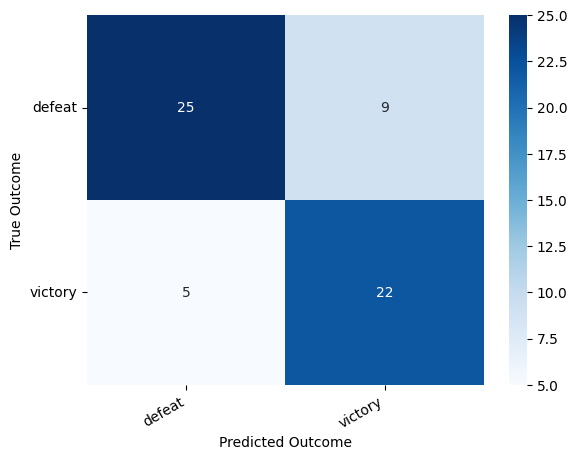

In [31]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Outcome')
  plt.xlabel('Predicted Outcome');

cm_bert = confusion_matrix(y_true, y_preds)
df_cm_bert = pd.DataFrame(cm_bert, index = list(label_encoder.classes_), columns = list(label_encoder.classes_))

show_confusion_matrix(df_cm_bert)

## **3.2 Emotional content of stories**

In [32]:
#Import in emotion detection model
pipe = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-emotion-multilabel-latest", return_all_scores=True)

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [33]:
#Function to calculate the average emotion scores for given text
def average_emotion_scores(emotion_score_list):

    emotion_sums = {}  # Dictionary to accumulate scores for each emotion
    emotion_counts = {}  # Dictionary to count occurrences of each emotion

    # Iterate over each sentences
    for sentence_scores in emotion_score_list:
        for emotion_data in sentence_scores:
            for item in emotion_data:
                emotion_label = item['label']
                emotion_score = item['score']

                # Accumulate the score for the current emotion
                emotion_sums[emotion_label] = emotion_sums.get(emotion_label, 0) + emotion_score
                # Increment the count for the current emotion
                emotion_counts[emotion_label] = emotion_counts.get(emotion_label, 0) + 1

    # Calculate the average score for each emotion
    average_scores = {}
    for emotion, total_score in emotion_sums.items():
        average_scores[emotion] = total_score / emotion_counts[emotion]

    return average_scores

In [34]:
all_story_emotion_scores = []
hightest_emotion_score = []

#Iterate through each story by sentence
for s in stories_df["story"]:
  sentences = sent_tokenize(s)

  emotion_score_list = []
  for sent in sentences:
    emotion_scores = pipe(sent) #Emotion scores for each sentence found and appended to list
    emotion_score_list.append(emotion_scores)

  average_scores = average_emotion_scores(emotion_score_list) #Average emotion scores found for story
  hightest_emotion_score.append(max(average_scores, key = average_scores.get)) #Emotion with the highest score found

  all_story_emotion_scores.append(average_scores)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [35]:
#Column created in dataframe to store the computed emotion for each story
stories_df['Emotion'] = hightest_emotion_score

#Group the dataframe by story theme and emotion and unstack
x = stories_df.groupby(['theme', 'Emotion']).size().unstack(fill_value=0)

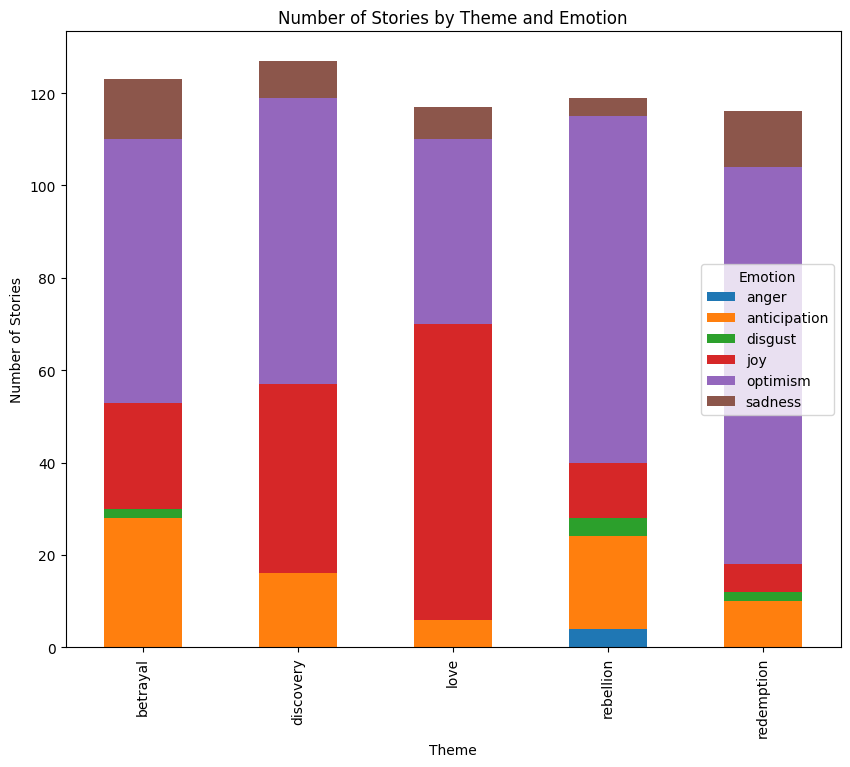

In [36]:
x.plot(kind='bar', stacked=True, figsize  =(10,8))
plt.xlabel('Theme')
plt.ylabel('Number of Stories')
plt.title('Number of Stories by Theme and Emotion')
plt.show()